# Data preprocessing

We have collected a dataset with a total of 826 rows that include molecule names, SMILES, oxidation or reduction potential values, labels, solvent SMILES (used for oxidation and reduction), and reference electrodes. This dataset consists of many classes, among them alkanes, alkenes, alkynes, substituted aromatics, quinones, and even salts, cations, anions, nitroxides, and radicals.

We believe that such broadness allows other research groups to use this dataset for their tasks. Our goal is to select molecules that potentially can be used in redox processes in spent nuclear fuel processing.



In [1]:
!pip install rdkit-pypi
!pip install Pillow
!pip install cirpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cirpy: filename=CIRpy-1.0.2-py3-none-any.whl size=7263 sha256=c35613d053fc65a2d6502d65e8c1418178f7f0ffdc0f0a03cd6043ce3618918b
  Stored in directory: /root/.cache/pip/wheels/c7/35/2b/f5d2226974fb5b1e84d53eda475d8b33a38548a6b25e32c2c0
Successfully built cirpy


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import os, sys
import cirpy
import scipy
import warnings


from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import CalcNumAtomStereoCenters
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.PandasTools import WriteSDF
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem

In [3]:
ds = pd.read_excel('Dataset_redox.xlsx')
ds.head()

,№,name,smiles,solvent_ox_smiles,solvent_red_smiles,reference electrode,label,E_ox,E_red
0,1,tetramethyl-p-dicyanobenzene,Cc1c(C)c(C#N)c(C)c(C)c1C#N,CC#N,CC#N,SCE,cyanoaromatics,NaN,-1.90
1,2,p-dicyanobenzene,N#Cc1ccc(cc1)C#N,CC#N,CC#N,SCE,cyanoaromatics,NaN,-1.60
2,3,tetrafluoro-p-dicyanobenzene,Fc1c(F)c(C#N)c(F)c(F)c1C#N,CC#N,CC#N,SCE,cyanoaromatics,NaN,-1.10
3,4,tetrachloro-p-dicyanobenzene,Clc1c(Cl)c(C#N)c(Cl)c(Cl)c1C#N,CC#N,CC#N,SCE,cyanoaromatics,NaN,-0.95
4,5,"1,2,4,5-tetracyanobenzene",N#Cc1cc(C#N)c(cc1C#N)C#N,CC#N,CC#N,SCE,cyanoaromatics,NaN,-0.74


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   №                    826 non-null    int64  
 1   name                 594 non-null    object 
 2   smiles               826 non-null    object 
 3   solvent_ox_smiles    826 non-null    object 
 4   solvent_red_smiles   826 non-null    object 
 5   reference electrode  826 non-null    object 
 6   label                651 non-null    object 
 7   E_ox                 612 non-null    float64
 8   E_red                260 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 58.2+ KB


In [5]:
# leaves only molecules with oxidation potential
ds_ox = ds.drop(columns=['E_red', '№', 'solvent_red_smiles'])

# Oxidation dataset

In [6]:
ds_ox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 594 non-null    object 
 1   smiles               826 non-null    object 
 2   solvent_ox_smiles    826 non-null    object 
 3   reference electrode  826 non-null    object 
 4   label                651 non-null    object 
 5   E_ox                 612 non-null    float64
dtypes: float64(1), object(5)
memory usage: 38.8+ KB


In [7]:
ds_ox = ds_ox.dropna(subset=['E_ox']) # removing molecules without oxidation potential

For oxidation processes, we need a general model that predicts oxidation potential in acetonitrile. Additionally, we need to adjust all potentials referenced to a common electrode (we chose saturated calomel electrode, SCE).

In [8]:
ds_ox = ds_ox[ds_ox['solvent_ox_smiles'] == 'CC#N']

In [9]:
ds_ox['reference electrode'].unique()

array(['SCE', 'SHE', 'NHE', 'Fc/Fc+'], dtype=object)

In [10]:
adjustment_dict = {'SCE': 0, 'Absolute potential of SHE': -4.422, 'SHE': -0.241, 'NHE': -0.241, 'Fc/Fc+': 0.40} # tabulated data

In [11]:
def adjust_potential_ox(row):
    electrode = row['reference electrode']
    potential = adjustment_dict.get(electrode, 0)
    return row['E_ox'] + potential

ds_ox['E_ox_adj'] = ds_ox.apply(adjust_potential_ox, axis=1)

ds_ox


,name,smiles,solvent_ox_smiles,reference electrode,label,E_ox,E_ox_adj
83,Toluene,Cc1ccccc1,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,2.36,2.36
84,o-Xylene,Cc1ccccc1C,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,2.22,2.22
85,m-Xylene,Cc1cccc(C)c1,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,2.22,2.22
86,Mesitylene,Cc1cc(C)cc(C)c1,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,2.07,2.07
87,Naphthalene,c1ccc2ccccc2c1,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,1.64,1.64
...,...,...,...,...,...,...,...
821,Mesitylene,Cc1cc(C)cc(C)c1,CC#N,SCE,NaN,1.80,1.80
822,o-Xylene,Cc1ccccc1C,CC#N,SCE,NaN,1.89,1.89
823,m-Xylene,Cc1cccc(C)c1,CC#N,SCE,NaN,1.91,1.91
824,Toluene,Cc1ccccc1,CC#N,SCE,NaN,1.98,1.98


There are cases when a single SMILES corresponds to multiple potential values from different literature sources. We decided to use the mean value in such cases.

In [12]:
ds_ox['E_ox_adj_mean'] = ds_ox.groupby('smiles')['E_ox_adj'].transform('mean')

In [13]:
ds_ox = ds_ox.drop_duplicates('smiles')
ds_ox

,name,smiles,solvent_ox_smiles,reference electrode,label,E_ox,E_ox_adj,E_ox_adj_mean
83,Toluene,Cc1ccccc1,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,2.36,2.36,2.216333
84,o-Xylene,Cc1ccccc1C,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,2.22,2.22,2.006333
85,m-Xylene,Cc1cccc(C)c1,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,2.22,2.22,2.093000
86,Mesitylene,Cc1cc(C)cc(C)c1,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,2.07,2.07,1.903000
87,Naphthalene,c1ccc2ccccc2c1,CC#N,SCE,Aromatic Hydrocarbons and Alkynes,1.64,1.64,1.644000
...,...,...,...,...,...,...,...,...
798,"5-Methyl-1,2-benz-anthracene",Cc1cc2cc3ccccc3cc2c4ccccc14,CC#N,SCE,NaN,1.15,1.15,1.150000
799,"6-Methyl-1,2-benz-anthracene",Cc1cc2ccccc2c3cc4ccccc4cc13,CC#N,SCE,NaN,1.15,1.15,1.150000
800,"9-Methyl-1,2-benz-anthracene",Cc1ccc2cc3c(ccc4ccccc34)cc2c1,CC#N,SCE,NaN,1.15,1.15,1.150000
801,"1,2,3,4-Dibenzpyrene",c1ccc2c(c1)cc3ccc4cccc5c6ccccc6c2c3c45,CC#N,SCE,NaN,1.15,1.15,1.150000


In [14]:
def wrong_smiles_remover(df):
    # List for correct SMILES indices
    valid_smiles_indices = []

    for i, smi in enumerate(df['smiles']):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                mol = Chem.MolFromSmiles(smi)

                if mol is not None:
                    charge = Chem.GetFormalCharge(mol)
                    has_radicals = any(atom.GetNumRadicalElectrons() > 0 for atom in mol.GetAtoms())

                    if charge == 0 and not has_radicals:
                        valid_smiles_indices.append(i)
        except (Chem.rdchem.KekulizeException, Chem.rdchem.AtomSanitizeException, Warning) as e:
            continue

    df = df.iloc[valid_smiles_indices]
    df = df.reset_index(drop=True)

    return df

In [15]:
ds_ox = wrong_smiles_remover(ds_ox)

[20:04:33] WARNING: not removing hydrogen atom without neighbors
[20:04:33] Explicit valence for atom # 0 C, 6, is greater than permitted


In [16]:
possible_atoms = ['C', 'H', 'O', 'N', 'F', 'Cl', 'Br', 'I']
# according to C, H, O, N principle. Add halogens to consider electronic effects

def is_mol_acceptable(mol: Chem.Mol) -> bool:
    for atom in mol.GetAtoms():
        if atom.GetSymbol() not in possible_atoms:
            return False
    return True

def filter_dataframe(df):
    acceptable_indices = []
    for index, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol and is_mol_acceptable(mol):
            acceptable_indices.append(index)

    return df.loc[acceptable_indices]

In [17]:
ds_ox = filter_dataframe(ds_ox)

[20:04:33] WARNING: not removing hydrogen atom without neighbors


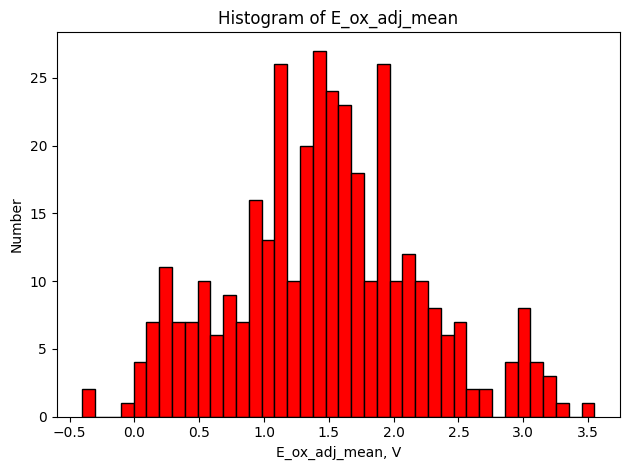

In [18]:
plt.hist(ds_ox['E_ox_adj_mean'], color = 'red', edgecolor = 'black',
         bins = 40)
plt.title('Histogram of E_ox_adj_mean')
plt.xlabel('E_ox_adj_mean, V')
plt.ylabel('Number')

plt.tight_layout()

plt.show()

In [19]:
ds_ox = ds_ox[(ds_ox['E_ox_adj_mean'] > 0.1) & (ds_ox['E_ox_adj_mean'] < 2.5)]

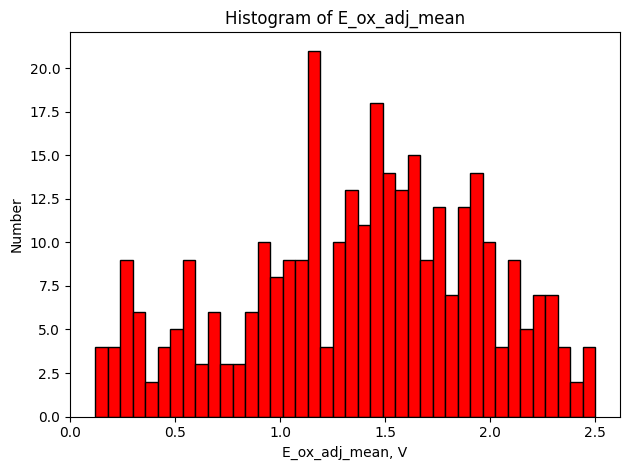

In [20]:
plt.hist(ds_ox['E_ox_adj_mean'], color = 'red', edgecolor = 'black',
         bins = 40)
plt.title('Histogram of E_ox_adj_mean')
plt.xlabel('E_ox_adj_mean, V')
plt.ylabel('Number')

plt.tight_layout()

plt.show()

In [21]:
ds_ox.to_csv('Dataset_oxidation.csv')

In [22]:
smiles_ox_list = ds_ox["smiles"].tolist()
mols_ox_list = []

for smi in smiles_ox_list:
  mols_ox_list.append(Chem.MolFromSmiles(smi))

[20:04:35] WARNING: not removing hydrogen atom without neighbors


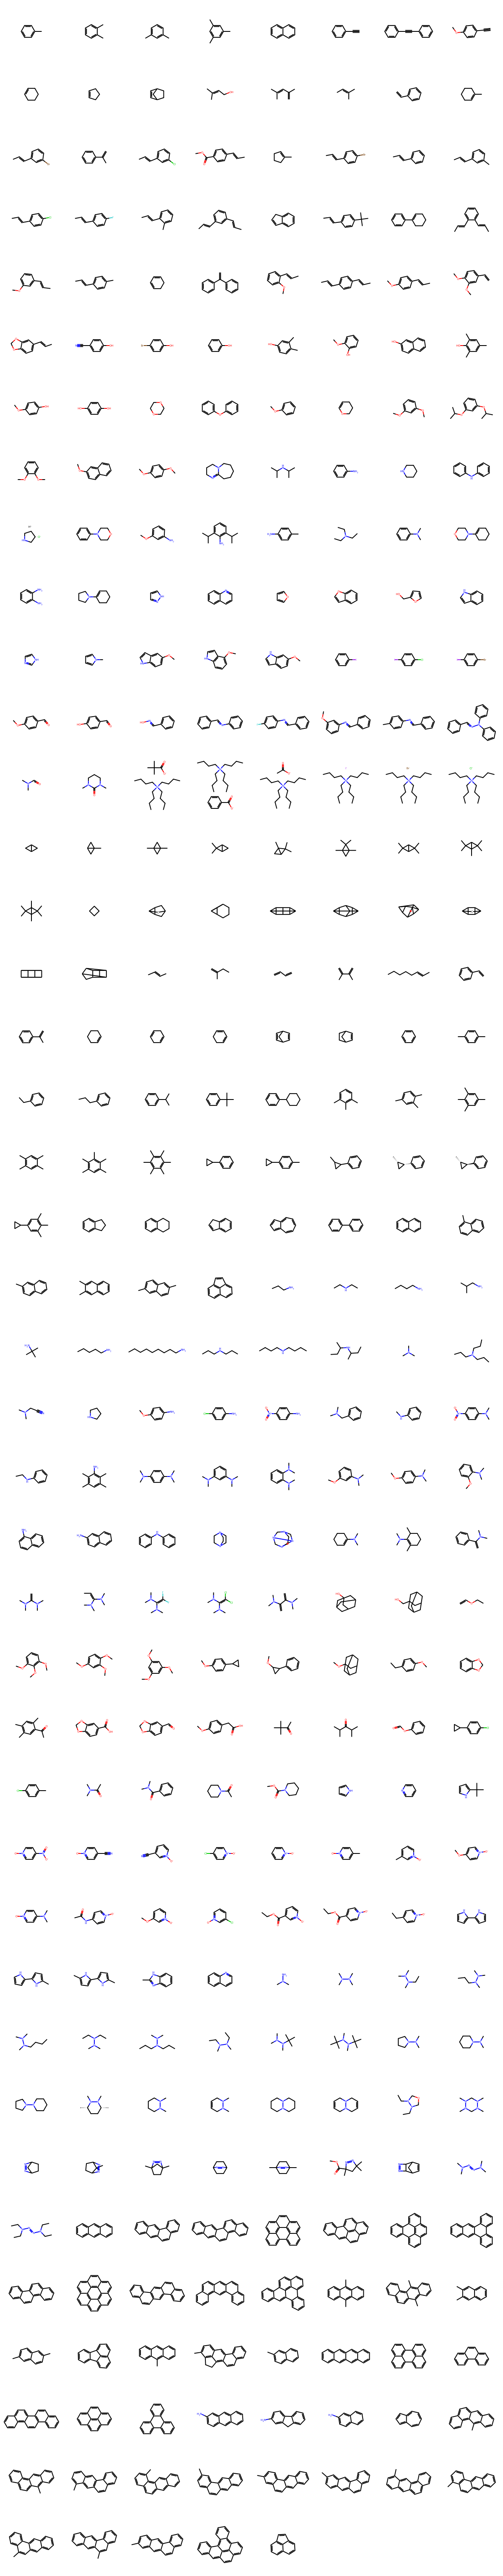

In [23]:
MolsToGridImage(mols_ox_list, molsPerRow=8, subImgSize=(150, 150), maxMols=400)